<a href="https://colab.research.google.com/github/mjmaher987/Stock-Prediction-Using-ML/blob/main/Codes/Stock-08302023-1342.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction

## Dependencies

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Reshape, Flatten, LSTM
import yfinance as yf
import matplotlib.pyplot as plt

## Configs

In [10]:
Configs = {
    "training_percent" : 0.8,
    "window_size" : 5,
    "epoch_number" : 50,
    "sequence_length" : 10,
    "num_features" : 5
}

## Preprocessing

In [11]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def get_history_from_yf(self):
        t = yf.Ticker(self.ticker)
        return t.history(period=self.period)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [12]:
etl_data = ETL('EURUSD=X')
history = etl_data.get_history_from_yf()

data = pd.DataFrame(
    {
        'open': pd.Series([x for x in history.Open]),
        'high': pd.Series([x for x in history.High]),
        'low': pd.Series([x for x in history.Low]),
        'close': pd.Series([x for x in history.Close]),
        'volume': pd.Series([x for x in history.Volume]),
    }
)

# Preprocessing
scaler = MinMaxScaler()
data['close'] = scaler.fit_transform(data['close'].values.reshape(-1, 1))

# Splitting into training and testing sets
train_size = int(Configs['training_percent'] * len(data))
train_data, test_data = data[:train_size], data[train_size:]

In [13]:
# Define the sequence length
sequence_length = Configs['sequence_length']
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data.iloc[i+sequence_length])
    return np.array(sequences), np.array(targets)
train_sequences, train_targets = create_sequences(train_data, sequence_length)
test_sequences, test_targets = create_sequences(test_data, sequence_length)

## Experiments

### Ichimoku

In [14]:
def calculate_ichimoku_cloud(df):
    # Tenkan-sen (Conversion Line) - Average of the highest high and lowest low over a certain period
    df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2

    # Kijun-sen (Base Line) - Average of the highest high and lowest low over a longer period
    df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2

    # Senkou Span A (Leading Span A) - Average of the Tenkan-sen and Kijun-sen, shifted forward
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)

    # Senkou Span B (Leading Span B) - Average of the highest high and lowest low over an even longer period, shifted forward
    df['senkou_span_b'] = ((df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2).shift(26)

    # Chikou Span (Lagging Span) - Close price shifted backward
    df['chikou_span'] = df['close'].shift(-26)

    return df[['tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span']]

# Calculate Ichimoku Cloud components
data_with_cloud = calculate_ichimoku_cloud(data)

def ichimoku_trading_strategy(df):
    signals = []
    for i in range(len(df)):
        if data['close'][i] > df['senkou_span_a'][i] and data['close'][i] > df['senkou_span_b'][i]:
            signals.append('Buy')
        elif data['close'][i] < df['senkou_span_a'][i] and data['close'][i] < df['senkou_span_b'][i]:
            signals.append('Sell')
        else:
            signals.append('Hold')
    return signals

# Generate trading signals using the Ichimoku-based strategy
trading_signals = ichimoku_trading_strategy(data_with_cloud)

# Print the trading signals
for i, signal in enumerate(trading_signals):
    print(f"Day {i + 1}: {signal}")

Streaming output truncated to the last 5000 lines.
Day 125: Sell
Day 126: Sell
...
...
...
Day 5121: Sell
Day 5122: Sell
Day 5123: Sell
Day 5124: Sell


In [15]:
data_with_cloud

,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span
0,NaN,NaN,NaN,NaN,0.488883
1,NaN,NaN,NaN,NaN,0.476354
2,NaN,NaN,NaN,NaN,0.497324
3,NaN,NaN,NaN,NaN,0.510457
4,NaN,NaN,NaN,NaN,0.492002
...,...,...,...,...,...
5119,1.088167,1.101632,1.104896,1.09637,NaN
5120,1.085818,1.095935,1.107506,1.09637,NaN
5121,1.085070,1.095935,1.109112,1.09637,NaN
5122,1.084935,1.095935,1.109967,1.09637,NaN


###NBEATS

In [17]:
class NBitsModel(tf.keras.Model):
    def __init__(self):
        super(NBitsModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(Configs['sequence_length'], 5))
        self.dense = tf.keras.layers.Dense(5)

    def call(self, inputs, training):
        x = self.flatten(inputs)
        x = self.dense(x)
        return x

model = NBitsModel()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_sequences, train_targets, epochs=Configs['epoch_number'], batch_size=32, validation_split=0.2)

# Make predictions
predictions_nbits = model.predict(test_sequences)
mse = mean_squared_error(test_targets, predictions_nbits)
mae = mean_absolute_error(test_targets, predictions_nbits)
rmse = mean_squared_error(test_targets, predictions_nbits, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Epoch 1/50
103/103 [==============================] - 2s 8ms/step - loss: 0.1709 - val_loss: 0.0130
Epoch 2/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0117
Epoch 3/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0079
Epoch 4/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 5/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 6/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 7/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 8/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013

###NHEATS

In [19]:
def build_nhits(input_shape, output_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(output_shape)
    ])
    return model

nhits_model = build_nhits((Configs['sequence_length'], 5), 5)
nhits_model.compile(optimizer='adam', loss='mean_squared_error')
nhits_model.fit(train_sequences, train_targets, epochs=Configs['epoch_number'], batch_size=32, validation_split=0.2)


nhits_predictions = nhits_model.predict(test_sequences)
mse = mean_squared_error(test_targets, nhits_predictions)
mae = mean_absolute_error(test_targets, nhits_predictions)
rmse = mean_squared_error(test_targets, nhits_predictions, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Epoch 1/50
103/103 [==============================] - 1s 4ms/step - loss: 0.0331 - val_loss: 0.0016
Epoch 2/50
103/103 [==============================] - 0s 3ms/step - loss: 6.8517e-04 - val_loss: 1.3864e-04
Epoch 3/50
103/103 [==============================] - 0s 3ms/step - loss: 5.2823e-04 - val_loss: 2.2425e-04
Epoch 4/50
103/103 [==============================] - 0s 2ms/step - loss: 5.1704e-04 - val_loss: 1.1985e-04
Epoch 5/50
103/103 [==============================] - 0s 2ms/step - loss: 5.0429e-04 - val_loss: 1.0061e-04
Epoch 6/50
103/103 [==============================] - 0s 2ms/step - loss: 4.9134e-04 - val_loss: 1.0621e-04
Epoch 7/50
103/103 [==============================] - 0s 5ms/step - loss: 5.1426e-04 - val_loss: 1.1195e-04
Epoch 8/50
103/103 [==============================] - 0s 3ms/step - loss: 5.0304e-04 - val_loss: 9.8528e-05
Epoch 9/50
103/103 [==============================] - 0s 4ms/step - loss: 5.0544e-04 - val_loss: 9.4078e-05
Epoch 10/50
103/103 [===============

###RNN

In [20]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, input_shape=(Configs['sequence_length'], 5), return_sequences=False),
    tf.keras.layers.Dense(5)
])

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(train_sequences, train_targets, epochs=Configs['epoch_number'], batch_size=32, validation_split=0.2)


# Make predictions
predictions_rnn = model_rnn.predict(test_sequences)
mse = mean_squared_error(test_targets, predictions_rnn)
mae = mean_absolute_error(test_targets, predictions_rnn)
rmse = mean_squared_error(test_targets, predictions_rnn, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Epoch 1/50
103/103 [==============================] - 2s 6ms/step - loss: 0.0380 - val_loss: 0.0016
Epoch 2/50
103/103 [==============================] - 0s 4ms/step - loss: 6.7384e-04 - val_loss: 2.2493e-04
Epoch 3/50
103/103 [==============================] - 0s 4ms/step - loss: 5.1583e-04 - val_loss: 1.0562e-04
Epoch 4/50
103/103 [==============================] - 0s 5ms/step - loss: 4.9577e-04 - val_loss: 1.1650e-04
Epoch 5/50
103/103 [==============================] - 0s 5ms/step - loss: 4.9508e-04 - val_loss: 1.5445e-04
Epoch 6/50
103/103 [==============================] - 0s 4ms/step - loss: 4.6277e-04 - val_loss: 8.7632e-05
Epoch 7/50
103/103 [==============================] - 0s 4ms/step - loss: 4.6514e-04 - val_loss: 6.9754e-05
Epoch 8/50
103/103 [==============================] - 0s 4ms/step - loss: 4.3564e-04 - val_loss: 9.7815e-05
Epoch 9/50
103/103 [==============================] - 0s 4ms/step - loss: 4.1846e-04 - val_loss: 1.5083e-04
Epoch 10/50
103/103 [===============

###LSTM

In [21]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, 5), return_sequences=False),
    tf.keras.layers.Dense(5)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

lstm_model.fit(train_sequences, train_targets, epochs=Configs['epoch_number'], batch_size=32, verbose=1)


lstm_predictions = lstm_model.predict(test_sequences)
mse = mean_squared_error(test_targets, lstm_predictions)
mae = mean_absolute_error(test_targets, lstm_predictions)
rmse = mean_squared_error(test_targets, lstm_predictions, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Epoch 1/50
128/128 [==============================] - 3s 8ms/step - loss: 0.0605
Epoch 2/50
128/128 [==============================] - 2s 17ms/step - loss: 0.0010
Epoch 3/50
128/128 [==============================] - 1s 11ms/step - loss: 4.0696e-04
Epoch 4/50
128/128 [==============================] - 1s 9ms/step - loss: 3.9569e-04
Epoch 5/50
128/128 [==============================] - 1s 7ms/step - loss: 3.9987e-04
Epoch 6/50
128/128 [==============================] - 1s 7ms/step - loss: 3.7819e-04
Epoch 7/50
128/128 [==============================] - 1s 7ms/step - loss: 4.0342e-04
Epoch 8/50
128/128 [==============================] - 1s 7ms/step - loss: 3.8793e-04
Epoch 9/50
128/128 [==============================] - 1s 7ms/step - loss: 3.9762e-04
Epoch 10/50
128/128 [==============================] - 1s 7ms/step - loss: 3.7041e-04
Epoch 11/50
128/128 [==============================] - 1s 7ms/step - loss: 3.7354e-04
Epoch 12/50
128/128 [==============================] - 1s 7ms/step - 

###Transformers

In [50]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)


transformer_model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  hist = transformer.fit(etl_data.X_train, etl_data.y_train, batch_size=32, epochs=Configs['epoch_number'], verbose=1, callbacks=callbacks)
  return hist


hist = fit_transformer(transformer_model)


Epoch 1/50
128/128 [==============================] - 13s 30ms/step - loss: 0.1644 - mae: 0.2402 - mape: 18.9900
Epoch 2/50
128/128 [==============================] - 3s 26ms/step - loss: 0.0120 - mae: 0.0863 - mape: 6.7960
Epoch 3/50
128/128 [==============================] - 3s 25ms/step - loss: 0.0091 - mae: 0.0750 - mape: 5.9081
Epoch 4/50
128/128 [==============================] - 4s 35ms/step - loss: 0.0077 - mae: 0.0695 - mape: 5.4660
Epoch 5/50
128/128 [==============================] - 3s 25ms/step - loss: 0.0068 - mae: 0.0648 - mape: 5.1042
Epoch 6/50
128/128 [==============================] - 4s 34ms/step - loss: 0.0061 - mae: 0.0617 - mape: 4.8552
Epoch 7/50
128/128 [==============================] - 5s 35ms/step - loss: 0.0057 - mae: 0.0599 - mape: 4.7162
Epoch 8/50
128/128 [==============================] - 3s 26ms/step - loss: 0.0052 - mae: 0.0570 - mape: 4.4885
Epoch 9/50
128/128 [==============================] - 3s 26ms/step - loss: 0.0046 - mae: 0.0538 - mape: 4.2350

In [26]:
transformer_predictions = transformer_model.predict(etl_data.X_test)
mse = mean_squared_error(test_targets, transformer_predictions[:1015])
mae = mean_absolute_error(test_targets, transformer_predictions[:1015])
rmse = mean_squared_error(test_targets, transformer_predictions[:1015], squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

32/32 [==============================] - 1s 22ms/step
Mean Squared Error: 0.4146265251861313
Mean Absolute Error: 0.4125690744934033
Root Mean Squared Error: 0.4151669836252273


## Visualizations

In [27]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='EURUSD price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))

  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')

  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')

  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  if image_path != None:
    imagedir = './result_plots'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

### NBits

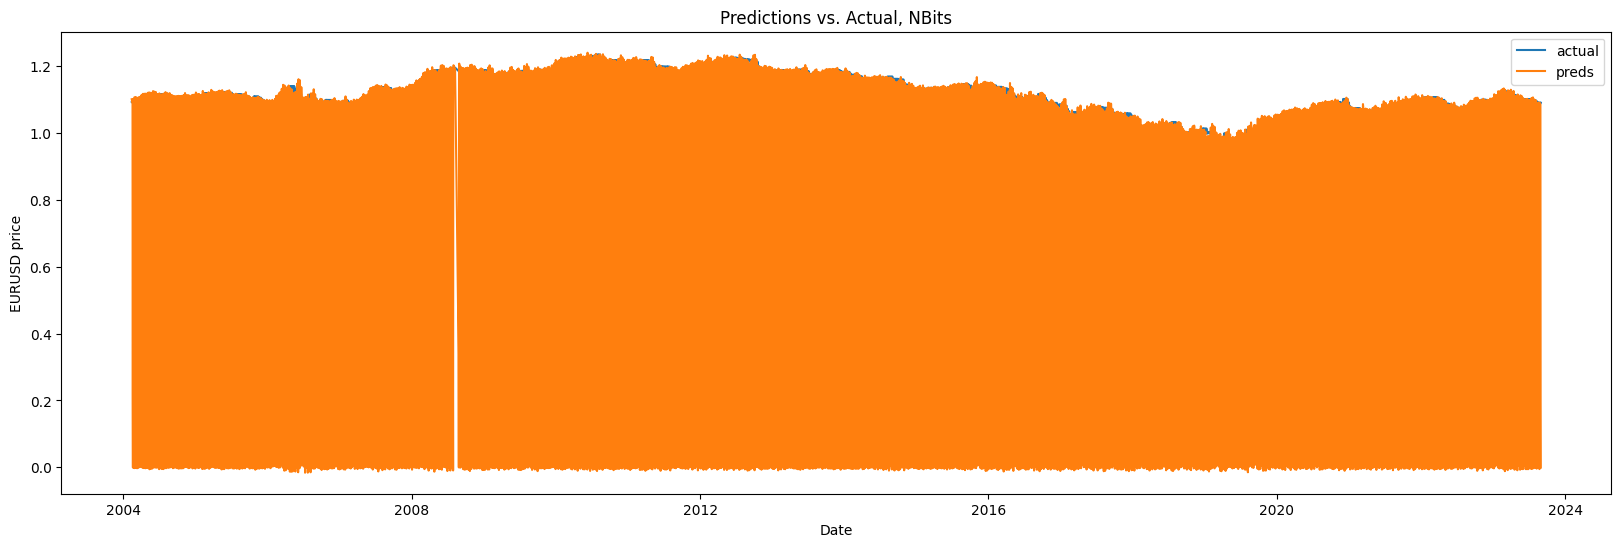

In [28]:
plot_results(etl_data.X_test[:1015], predictions_nbits, etl_data.df, title_suffix='NBits')

### NHeats

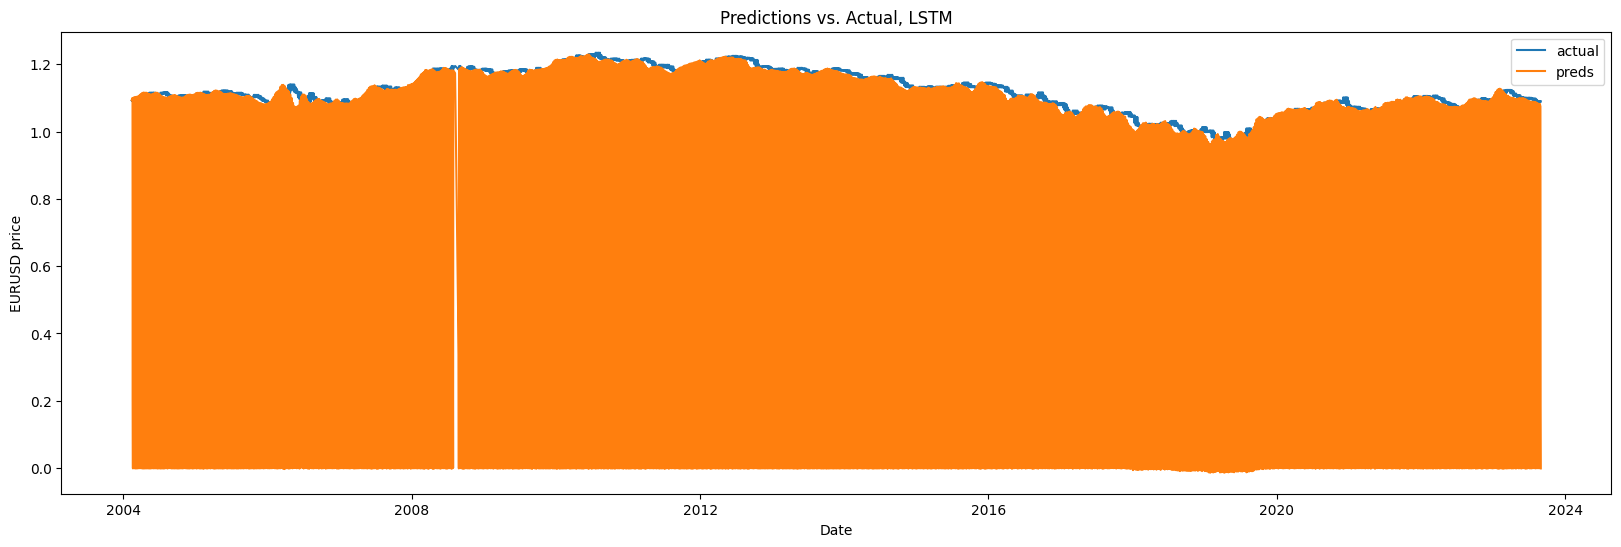

In [29]:
plot_results(etl_data.X_test[:1015], nhits_predictions, etl_data.df, title_suffix='LSTM')

### LSTM

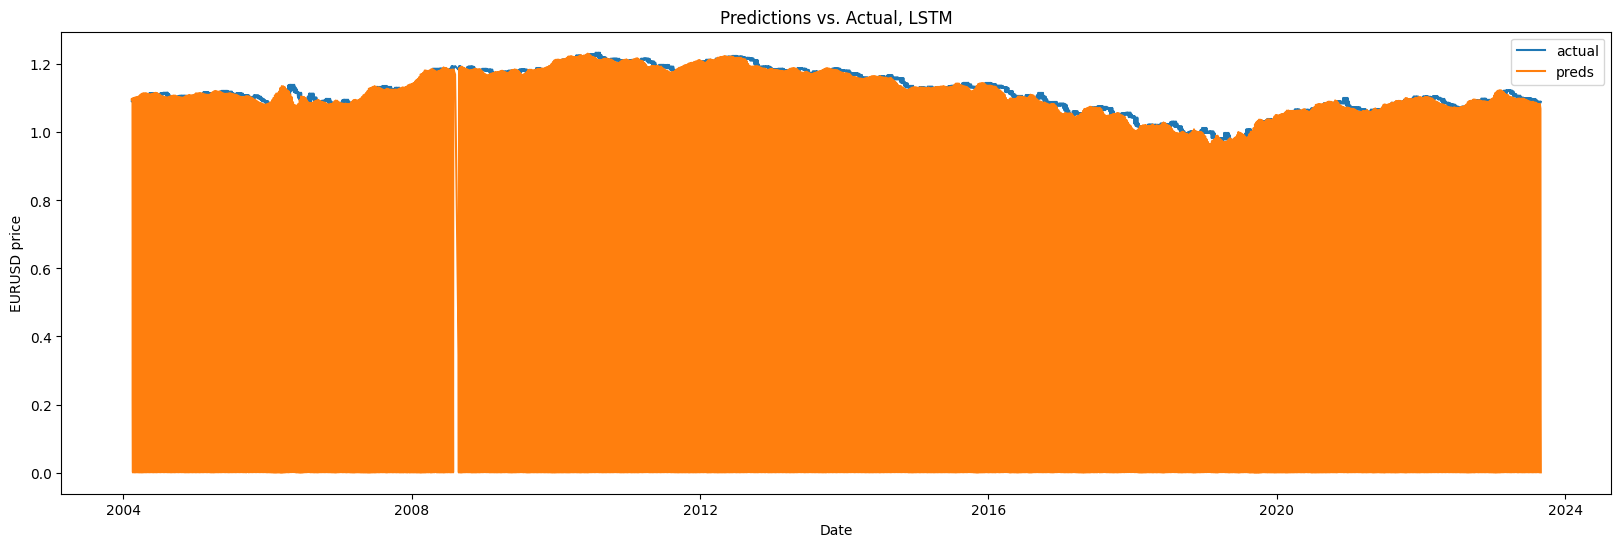

In [30]:
plot_results(etl_data.X_test[:1015], lstm_predictions, etl_data.df, title_suffix='LSTM')

## RNN

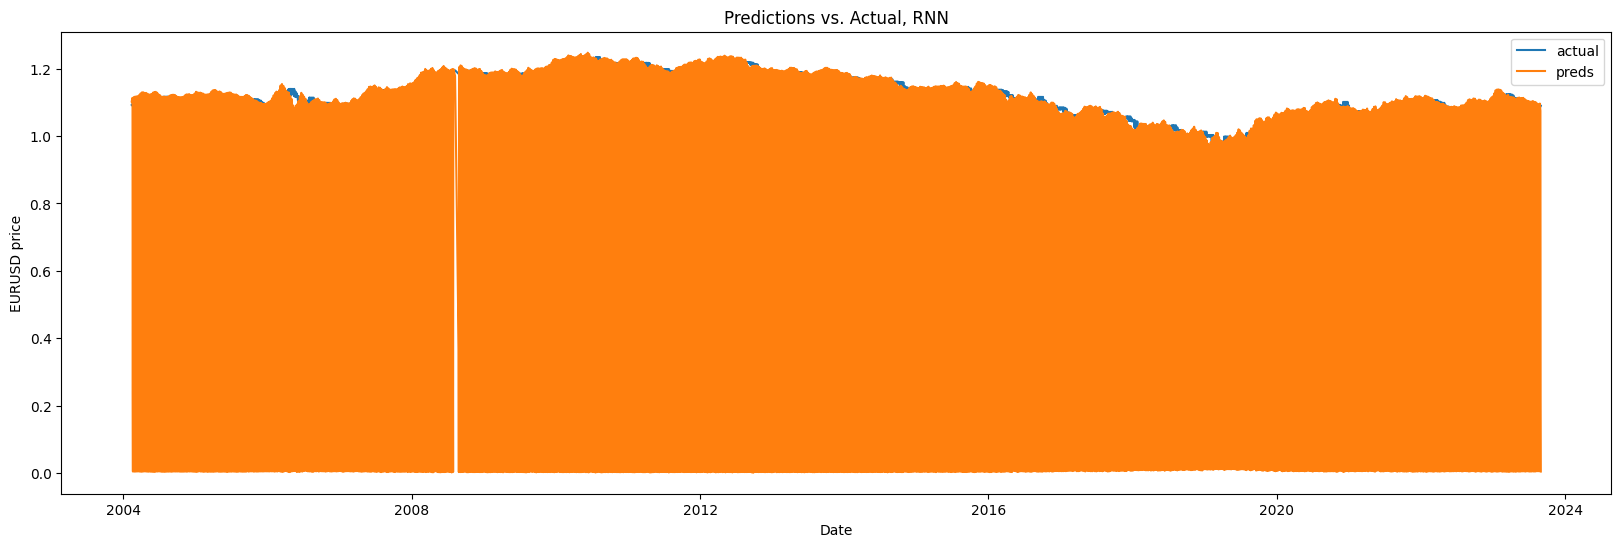

In [31]:
plot_results(etl_data.X_test[:1015], predictions_rnn, etl_data.df, title_suffix='RNN')

### Transformer

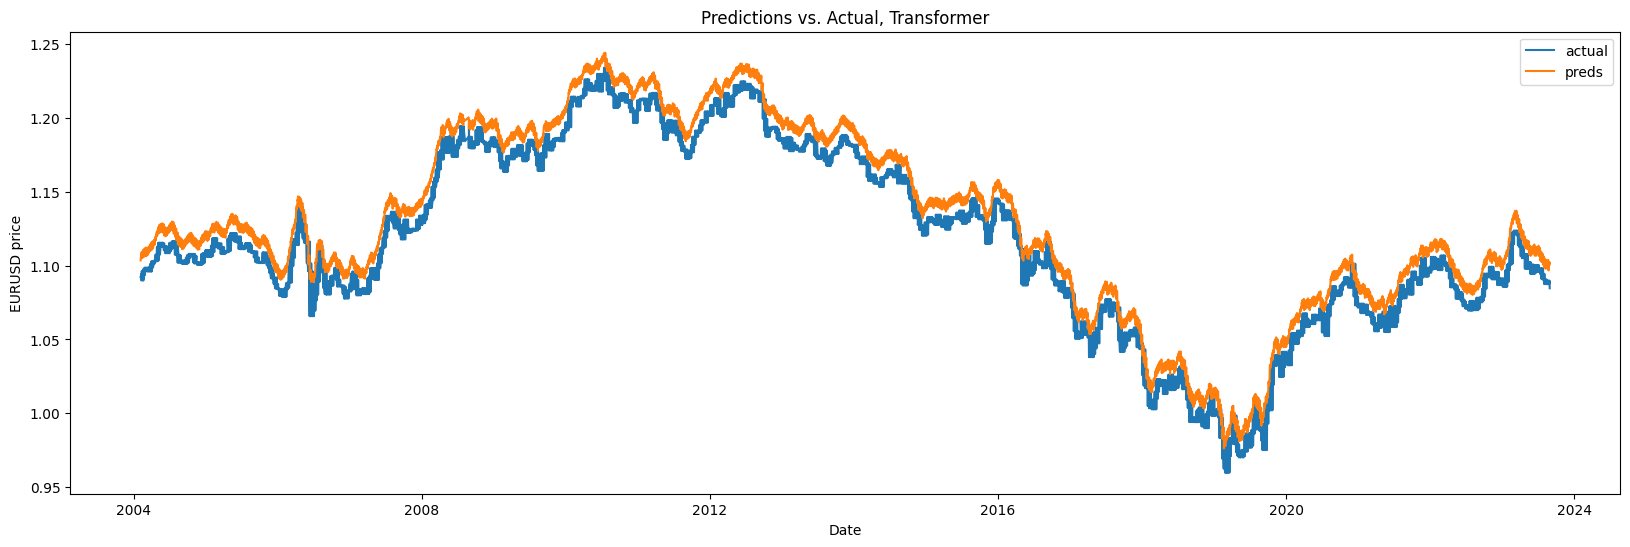

In [32]:
plot_results(etl_data.X_test, transformer_predictions, etl_data.df, title_suffix='Transformer')

Save and serialize models for the bot

In [ ]:
# save models for bot usage
nbeats_model.save('./model_dumps/nbeats.keras')
nhits_model.save('./model_dumps/nhits.keras')
rnn_model.save('./model_dumps/rnn.keras')
lstm_model.save('./model_dumps/lstm.keras')
transformer_model.save('./model_dumps/transformer.keras')